In [1]:
# Problem 2-(a)(1) Statevector_simulation
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from math import sqrt, pi

In [2]:
def create_bell_pair(qc, a, b):
    #Creates a bell pair in qc using qubits a & b
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
    
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
    
def measure_and_send(qc, a, b):
    #Measures qubits a & b and 'sends' the results to Bob
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

[-0.71656205+0.j         0.2901672 -0.6343042j]


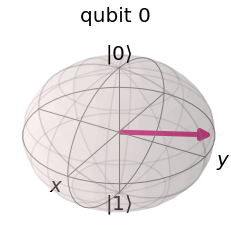

In [3]:
# Create one qubits and one classical bits
import random
q_init = QuantumRegister(1)
c_init = ClassicalRegister(1)

# Create a quantum circuit
cir_init = QuantumCircuit(q_init, c_init)
cir_init.u3(random.uniform(0, 2*pi), random.uniform(0, 2*pi), random.uniform(0, 2*pi), q_init[0])

sim_init = Aer.get_backend('statevector_simulator')
job_init = execute(cir_init, sim_init)
result_init = job_init.result()
statevector_init = result_init.get_statevector()
print(statevector_init)

init_gate = Initialize(statevector_init)
init_gate.label = "init"

# Show it on a Bloch sphere
plot_bloch_multivector(statevector_init)

In [4]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

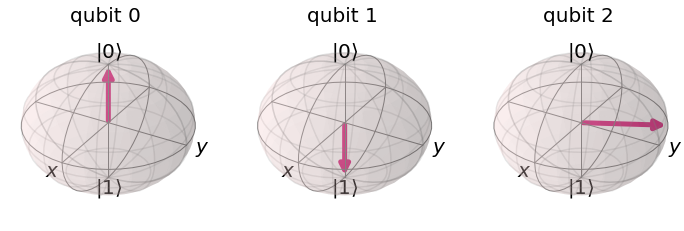

In [5]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

In [6]:
# Problem 2-(a)(2) Inverse Operation --> qasm_simulator

In [16]:
inverse_init_gate = init_gate.gates_to_uncompute()

## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

In [8]:
# Need to add a new ClassicalRegister to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)

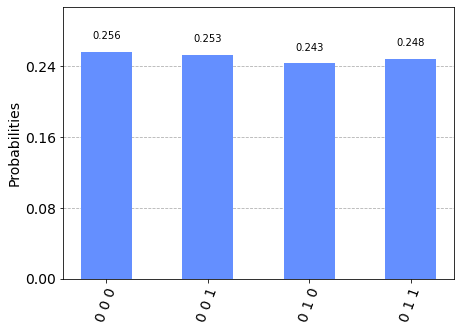

In [9]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [10]:
# Problem 2-(a)(3) Swap Test

In [19]:
## SETUP
qr = QuantumRegister(5, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
c_swap = ClassicalRegister(2, name="c_swap")
qc = QuantumCircuit(qr, crz, crx, c_swap)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

In [20]:
# states are the same --> output: '100'
qc.append(init_gate, [0])
qc.h(qr[4])
qc.cswap(qr[4], qr[2], qr[0])
qc.h(qr[4])

# Draw circuit
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐┌──────┐                   »
     q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├┤ init ├───────────────────»
          └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘└─┬─┬──┘                   »
     q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫───┤M├──────────────────────»
                   ░ └───┘┌─┴─┐ ░ └───┘      ░  ║   └╥┘         ┌───┐  ┌───┐ »
     q_2: ─────────░──────┤ X ├─░────────────░──╫────╫──────────┤ X ├──┤ Z ├─»
                   ░      └───┘ ░            ░  ║    ║          └─┬─┘  └─┬─┘ »
     q_3: ─────────░────────────░────────────░──╫────╫────────────┼──────┼───»
                   ░            ░            ░  ║    ║    ┌───┐   │      │   »
     q_4: ─────────░────────────░────────────░──╫────╫────┤ H ├───┼──────┼───»
                   ░            ░            ░  ║    ║    └───┘   │   ┌──┴──┐»
   crz: 1/══════════════════════════════════════╩════╬════════════╪═══╡ = 1 ╞»
                                                0    ║         ┌──┴──┐└─────┘»
   crx: 1/═══════════════════════════════════════════╩═════════╡ = 1 ╞═══════»
                                                     0         └─────┘       »
c_swap: 2/═══════════════════════════════════════════════════════════════════»
                                                                             »
«                  
«     q_0: ─X──────
«           │      
«     q_1: ─┼──────
«           │      
«     q_2: ─X──────
«           │      
«     q_3: ─┼──────
«           │ ┌───┐
«     q_4: ─■─┤ H ├
«             └───┘
«   crz: 1/════════
«                  
«   crx: 1/════════
«                  
«c_swap: 2/════════
«

{'00 0 0': 252, '00 0 1': 245, '00 1 0': 259, '00 1 1': 268}


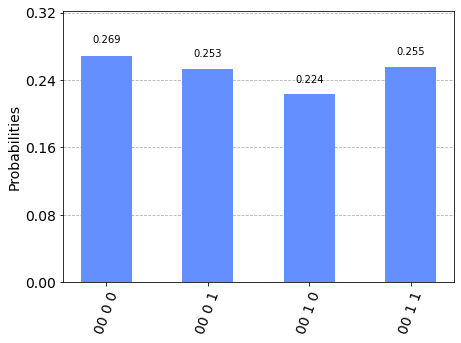

In [21]:
# Measure > {'01': 1024}
qc.measure(qr[4], c_swap[1])
sim_swap = Aer.get_backend('qasm_simulator')
job_swap = execute(qc, sim_swap, shots=1024)
result_swap = job_swap.result()
counts = result_swap.get_counts()
print(counts)

backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [22]:
# Problem 2-(b) Entanglement Swapping
q_es = QuantumRegister(4, 'q')
c_es = ClassicalRegister(2, 'c')
cir_es = QuantumCircuit(q_es, c_es)

cir_es.h(q_es[0])
cir_es.h(q_es[2])
cir_es.cx(q_es[0], q_es[1])
cir_es.cx(q_es[2], q_es[3])
cir_es.cx(q_es[1], q_es[2])
cir_es.h(q_es[1])
cir_es.cx(q_es[2], q_es[3])
# Control-Z (cz) gate
cir_es.cz(q_es[1], q_es[3])

#Measure
cir_es.measure([0, 3], [0, 1])

cir_es.draw()

┌───┐          ┌─┐           
q_0: ┤ H ├──■───────┤M├───────────
     └───┘┌─┴─┐     └╥┘┌───┐      
q_1: ─────┤ X ├──■───╫─┤ H ├─■────
     ┌───┐└───┘┌─┴─┐ ║ └───┘ │    
q_2: ┤ H ├──■──┤ X ├─╫───■───┼────
     └───┘┌─┴─┐└───┘ ║ ┌─┴─┐ │ ┌─┐
q_3: ─────┤ X ├──────╫─┤ X ├─■─┤M├
          └───┘      ║ └───┘   └╥┘
c: 2/════════════════╩══════════╩═
                     0          1

{'00': 490, '11': 534}


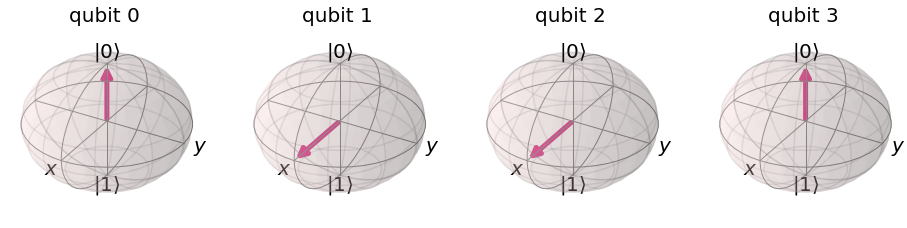

In [23]:
# Measure > {'01': 1024}

sim1 = Aer.get_backend('qasm_simulator')
job1 = execute(cir_es, sim1, shots=1024)
result1 = job1.result()
counts1 = result1.get_counts()
print(counts1)

backend1 = BasicAer.get_backend('statevector_simulator')
out_vector1 = execute(cir_es, backend1).result().get_statevector()
plot_bloch_multivector(out_vector1)